In [31]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各路徑指定

In [32]:
dataset = 'pose10.csv'
model_save_path = 'pose022.hdf5'

# 分類数設定


In [33]:
NUM_CLASSES = 4

# 讀取學習數據

In [34]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 42+ 1)))

In [35]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 模型構建



In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42, )),
    #tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense((42//2)+1, activation='relu'),
    #tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense((42//4)+1, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 

In [38]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 42)                1806      
                                                                 
 dense_8 (Dense)             (None, 22)                946       
                                                                 
 dense_9 (Dense)             (None, 11)                253       
                                                                 
 dense_10 (Dense)            (None, 4)                 48        
                                                                 
Total params: 3,053
Trainable params: 3,053
Non-trainable params: 0
_________________________________________________________________


In [39]:
# 模型檢查點回調
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期終止用回撥函數
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [40]:
# 模型編譯
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 模型訓練

In [41]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=90,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/100


68/70 [============================>.] - ETA: 0s - loss: 1.2929 - accuracy: 0.3995
Epoch 1: saving model to pose022.hdf5
70/70 [==============================] - 1s 4ms/step - loss: 1.2908 - accuracy: 0.4013 - val_loss: 1.2364 - val_accuracy: 0.4455
Epoch 2/100
35/70 [==============>...............] - ETA: 0s - loss: 1.2394 - accuracy: 0.4381
Epoch 2: saving model to pose022.hdf5
70/70 [==============================] - 0s 2ms/step - loss: 1.2158 - accuracy: 0.4582 - val_loss: 1.1717 - val_accuracy: 0.4880
Epoch 3/100
62/70 [=========================>....] - ETA: 0s - loss: 1.1550 - accuracy: 0.4927
Epoch 3: saving model to pose022.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 1.1511 - accuracy: 0.4954 - val_loss: 1.0853 - val_accuracy: 0.5115
Epoch 4/100
67/70 [===========================>..] - ETA: 0s - loss: 1.0896 - accuracy: 0.5114
Epoch 4: saving model to pose022.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 1.0880 - accuracy: 0.5113 - val_

In [42]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/17 [>.............................] - ETA: 0s - loss: 0.3529 - accuracy: 0.8828

17/17 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.9125


In [43]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [44]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 59ms/step
[9.3901503e-01 5.9147298e-02 1.8347984e-03 2.8629640e-06]
0


# 混同行列

66/66 [==============================] - 0s 1ms/step


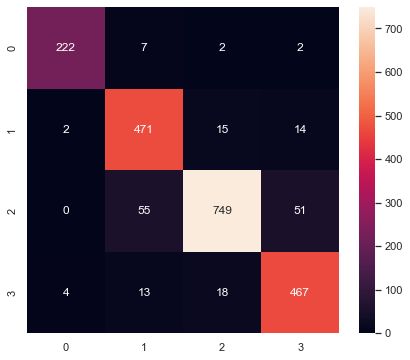

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       233
           1       0.86      0.94      0.90       502
           2       0.96      0.88      0.91       855
           3       0.87      0.93      0.90       502

    accuracy                           0.91      2092
   macro avg       0.92      0.92      0.92      2092
weighted avg       0.92      0.91      0.91      2092



In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    sns.set(font_scale=1)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)